In [26]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm

import random

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [18]:
IMG_SIZE = 32
BATCH_SIZE = 16
NUM_EPOCHS = num_epochs = 10


In [4]:
TRAIN_PATH = '../data/train/'
TEST_PATH = '../data/test/'

classes = [
    'meningioma', # 1
    'notumor', # 0
]

In [5]:
class BrainDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.images = []
        self.labels = []

        for i, cls in enumerate(classes):
            for file in os.listdir(os.path.join(path, cls)):
                self.images.append(os.path.join(path, cls, file))
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = plt.imread(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
class SiameseBrainDataset(Dataset):
    def __init__(self, path, n_pairs=1000, transform=None):
        self.path = path
        self.transform = transform
        self.n_pairs = n_pairs
        
        # Store images paths and labels
        self.images = []
        self.labels = []
        
        # Load all images and labels
        for i, cls in enumerate(classes):
            for file in os.listdir(os.path.join(path, cls)):
                self.images.append(os.path.join(path, cls, file))
                self.labels.append(i)
                
        # Convert to numpy arrays for easier indexing
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)
        
        # Create pairs
        self.create_pairs()
        
    def create_pairs(self):
        self.pairs = []
        self.pair_labels = []
        
        # Generate similar pairs (same class)
        n_same = self.n_pairs // 2
        for _ in range(n_same):
            # Pick a random class
            c = random.choice(np.unique(self.labels))
            # Find all indices for this class
            idx = np.where(self.labels == c)[0]
            # Pick two random images from this class
            if len(idx) >= 2:
                i1, i2 = random.sample(list(idx), 2)
                self.pairs.append((self.images[i1], self.images[i2]))
                self.pair_labels.append(1)  # Similar pair
        
        # Generate dissimilar pairs (different classes)
        for _ in range(self.n_pairs - n_same):
            # Pick two different classes
            c1, c2 = random.sample(list(np.unique(self.labels)), 2)
            # Find indices for each class
            idx1 = np.where(self.labels == c1)[0]
            idx2 = np.where(self.labels == c2)[0]
            # Pick one random image from each class
            i1 = random.choice(idx1)
            i2 = random.choice(idx2)
            self.pairs.append((self.images[i1], self.images[i2]))
            self.pair_labels.append(0)  # Dissimilar pair
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img1_path, img2_path = self.pairs[idx]
        label = self.pair_labels[idx]
        
        # Load images
        img1 = plt.imread(img1_path)
        img2 = plt.imread(img2_path)
        
        # Apply transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        # Stack images along a new dimension
        image_pair = torch.stack([img1, img2])
        
        return image_pair, label

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    # Grayscale
    transforms.Grayscale(3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Create datasets and dataloaders
train_dataset = SiameseBrainDataset(
    TRAIN_PATH, 
    n_pairs=5000,  # Adjust number of pairs as needed
    transform=train_transform
)

test_dataset = SiameseBrainDataset(
    TEST_PATH, 
    n_pairs=1000,  # Adjust number of pairs as needed
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SiameseNetwork, self).__init__()
        
        # Load two pretrained ResNet50 architectures
        self.resnet = models.resnet50(pretrained=True)
        
        # Replace the final fully connected layer with an embedding layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, embedding_dim)
        # self.resnet2.fc = nn.Linear(num_features, embedding_dim)
        
        # Add a normalization layer for embeddings
        self.l2_norm = nn.functional.normalize

    def forward_once(self, x, branch="resnet1"):
        """Forward pass through one of the ResNet branches."""
        if branch == "resnet1":
            return self.l2_norm(self.resnet(x), dim=1)
        elif branch == "resnet2":
            return self.l2_norm(self.resnet(x), dim=1)
        else:
            raise ValueError("branch should be 'resnet1' or 'resnet2'.")

    def forward(self, x1, x2):
        """Forward pass through the Siamese network."""
        # Pass the inputs through their respective ResNet branches
        embedding1 = self.forward_once(x1, branch="resnet1")
        embedding2 = self.forward_once(x2, branch="resnet2")
        
        return embedding1, embedding2

# Instantiate the model
model = SiameseNetwork(embedding_dim=128)
model = model.to(device)

/opt/anaconda3/envs/ics5200/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ics5200/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def contrastive_loss(embedding1, embedding2, label, margin=1.0):
    # Calculate euclidean distance
    distance = torch.nn.functional.pairwise_distance(embedding1, embedding2)
    
    # Calculate loss components
    similar_pair_loss = label * torch.pow(distance, 2)
    dissimilar_pair_loss = (1-label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2)
    
    # Total loss
    loss = (similar_pair_loss + dissimilar_pair_loss) / 2.0
    
    return loss.mean()

In [9]:
def train(model, train_loader, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for i, (img_pairs, labels) in enumerate(train_loader):
        # Expect img_pairs to be pairs of images
        img1, img2 = img_pairs[:, 0], img_pairs[:, 1]  # Split pairs
        img1, img2 = img1.to(device), img2.to(device)
        labels = labels.float().to(device)  # Convert labels to float

        optimizer.zero_grad()

        # Forward pass through the Siamese network
        embeddings1, embeddings2 = model(img1, img2)

        # Calculate contrastive loss
        loss = contrastive_loss(embeddings1, embeddings2, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 5 == 0:  # Print every 100 batches
            print(f"Batch {i + 1}/{len(train_loader)} - "
                  f"Loss: {loss.item():.4f}, "
                  f"Running loss: {(running_loss / (i + 1)):.4f}")

    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

def train_siamese(model, train_loader, num_epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)
        
        epoch_loss = train(model, train_loader, optimizer, device)
        history.append(epoch_loss)
        
        print(f"Epoch {epoch+1} - Average Loss: {epoch_loss:.4f}")
    
    return history
    

In [10]:
train_siamese(model, train_loader, num_epochs=5, device=device)


Epoch 1/5
--------------------
Batch 5/313 - Loss: 0.1434, Running loss: 0.1688
Batch 10/313 - Loss: 0.1030, Running loss: 0.1531
Batch 15/313 - Loss: 0.0766, Running loss: 0.1385
Batch 20/313 - Loss: 0.0838, Running loss: 0.1326
Batch 25/313 - Loss: 0.1294, Running loss: 0.1295
Batch 30/313 - Loss: 0.1121, Running loss: 0.1270
Batch 35/313 - Loss: 0.0854, Running loss: 0.1241
Batch 40/313 - Loss: 0.0975, Running loss: 0.1216
Batch 45/313 - Loss: 0.0943, Running loss: 0.1184
Batch 50/313 - Loss: 0.1616, Running loss: 0.1182
Batch 55/313 - Loss: 0.0983, Running loss: 0.1195
Batch 60/313 - Loss: 0.0824, Running loss: 0.1168
Batch 65/313 - Loss: 0.0849, Running loss: 0.1162
Batch 70/313 - Loss: 0.0600, Running loss: 0.1158
Batch 75/313 - Loss: 0.1079, Running loss: 0.1156
Batch 80/313 - Loss: 0.1284, Running loss: 0.1167
Batch 85/313 - Loss: 0.1199, Running loss: 0.1171
Batch 90/313 - Loss: 0.1212, Running loss: 0.1191
Batch 95/313 - Loss: 0.1284, Running loss: 0.1188
Batch 100/313 - Los

KeyboardInterrupt: 

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(model, test_loader, device, threshold=0.5):
    model.eval()
    total_pairs = 0
    correct = 0
    all_distances = []
    all_labels = []
    all_predictions = []
    running_loss = 0.0

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            img1 = images[:, 0, :, :, :].to(device)
            img2 = images[:, 1, :, :, :].to(device)
            labels = labels.float().to(device)

            embeddings1, embeddings2 = model(img1, img2)

            distances = torch.nn.functional.pairwise_distance(embeddings1, embeddings2)
            loss = contrastive_loss(embeddings1, embeddings2, labels)
            running_loss += loss.item()

            predictions = (distances < threshold).float()
            
            total_pairs += labels.size(0)
            correct += (predictions == labels).sum().item()
            
            all_distances.extend(distances.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate all metrics
    accuracy = correct / total_pairs
    avg_loss = running_loss / len(test_loader)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    fpr, tpr, thresholds = roc_curve(all_labels, [-d for d in all_distances])
    auc_score = auc(fpr, tpr)

    print(f"\nTest Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'average_loss': avg_loss,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }


Test Results:
Average Loss: 0.1113
Accuracy: 0.6810
Precision: 0.6704
Recall: 0.7120
F1-Score: 0.6906
AUC Score: 0.7462


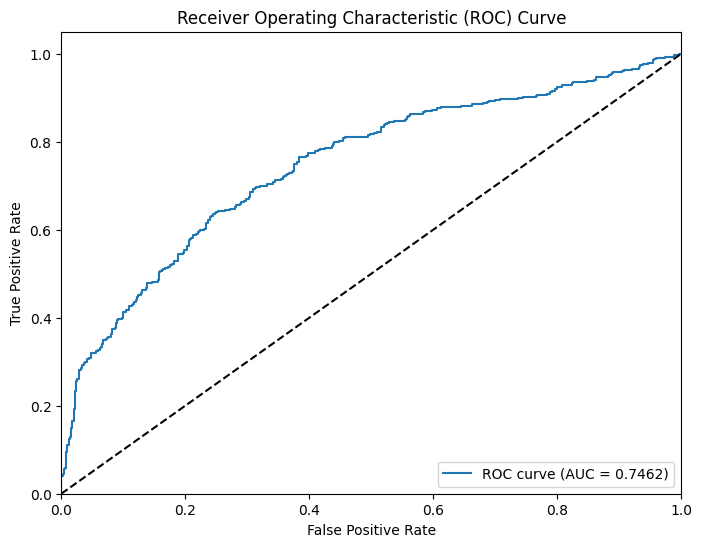

In [31]:
metrics = evaluate(model, test_loader, device, threshold=0.5)

In [29]:
def find_best_threshold(fpr, tpr, thresholds):
    # Find threshold that maximizes true positive rate while minimizing false positive rate
    optimal_idx = np.argmax(tpr - fpr)
    return thresholds[optimal_idx]

metrics = evaluate(model, test_loader, device)
best_threshold = find_best_threshold(metrics['fpr'], metrics['tpr'], metrics['thresholds'])
print(f"Best threshold: {best_threshold:.4f}")


Test Results:
Average Loss: 0.1113
Accuracy: 0.6810
Precision: 0.6704
Recall: 0.7120
F1-Score: 0.6906
AUC Score: 0.7462
Best threshold: -0.3332
